In [9]:
from typing import List

import torch
import torch.cuda
from torch.utils.data import DataLoader
from typing import Union
from datetime import datetime

from PIL import Image as PILImage

import numpy as np
import pyml
from models import DiscriminatorPixelMse, DownSampler, GeneratorESPCN, DiscriminatorVggMse, DiscriminatorBaselineNetwork

In [10]:
torch.cuda.is_available()

True

In [11]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 8

if torch.cuda.is_available():
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 4
        self.generator = GeneratorESPCN(channels=128, upscale=scale).to(self.device)

        self.d_pixel_mse = DiscriminatorPixelMse(weight=1.0)
        self.d_vgg_mse = DiscriminatorVggMse(weight=0.0001, inpad_size=16).to(self.device)
        self.d_vgg_mse_x2 = DiscriminatorVggMse(weight=0.0001, prescale=2, inpad_size=16).to(self.device)
        self.d_baseline = DiscriminatorBaselineNetwork(generator_weight=0.0001, mid_channels=32, inpad_size=16, dropout=0.5).to(self.device)

        self.downsampler = DownSampler(scale=scale).to(self.device)

        self.losses = []
        self.losses_print_step = 50

    def add_loss(self, losses: List[torch.Tensor]):
        self.losses.append([loss.item() for loss in losses])
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(np.array(self.losses[-self.losses_print_step:]), axis=0)
            print(f"{len(self.losses)}: {av_loss}")

    def train(self, *, steps: int, lr_g: float = 0.0, lr_d: float = 0.0):
        generator_optimizer = torch.optim.AdamW([
            {'params': self.generator.layers.parameters()},
            {'params': self.generator.pixel_shuffle.parameters(), 'lr': lr_g * 0.1}
        ], lr=lr_g)
        discriminator_optimizer = torch.optim.AdamW(self.d_baseline.parameters(), lr=lr_d)

        self.generator.train()
        self.d_baseline.train()

        step = 0
        while True:
            for label in self.data_loader:
                label = label.to(self.device)
                label.requires_grad = False
                x = self.downsampler(label)
                x = x.detach()

                # train generator
                if lr_g != 0.0:
                    generator_optimizer.zero_grad()
                    y = self.generator(x)
                    g_losses = [f.loss(y, label) for f in [self.d_pixel_mse, self.d_vgg_mse, self.d_vgg_mse_x2, self.d_baseline]]
                    loss = sum(g_losses)
                    loss.backward()
                    generator_optimizer.step()
                else:
                    g_losses = [torch.zeros(size=[1], device=self.device)]

                # train discriminator
                if lr_d != 0.0:
                    discriminator_optimizer.zero_grad()
                    y = self.generator(x)
                    y = y.detach()
                    d_loss = self.d_baseline.loss_for_discriminator(y, label)
                    d_loss.backward()
                    discriminator_optimizer.step()
                else:
                    d_loss = torch.zeros(size=[1], device=self.device)

                self.add_loss(g_losses + [d_loss])

                step += 1
                if step >= steps:
                    return

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor]) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        self.generator.eval()
        x = self.downsampler(label)
        y = self.generator(x)
        x4x = self.downsampler.upsample(x)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        torch.save(self.d_baseline.state_dict(), f"models/espcn/discriminator_baseline_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))
        self.d_baseline.load_state_dict(torch.load(f"models/espcn/discriminator_baseline_{suffix}.pth"))

In [13]:
gan_helper = GanHelper(data_loader)

/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [14]:
gan_helper.train(steps=1 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.0001)

50: [1.24944192e-01 1.93780993e-02 2.40645586e-02 1.08919072e-04
 6.00615512e-01]
100: [3.17647172e-02 1.63179169e-02 2.17254720e-02 1.34168016e-04
 5.06543208e-01]


In [15]:
gan_helper.train(steps=5 * len(dataset) // batch_size, lr_g=0.001, lr_d=0.001)

150: [2.76762808e-02 1.97697617e-02 2.16767763e-02 1.54203293e-04
 4.66299761e-01]
200: [1.31807723e-02 1.61010085e-02 1.69059094e-02 1.22179016e-04
 5.47399592e-01]
250: [9.28861745e-03 1.45847947e-02 1.38358001e-02 1.30831904e-04
 5.10581583e-01]
300: [7.03260214e-03 1.23022506e-02 1.01661390e-02 1.84983304e-04
 3.89982865e-01]
350: [6.13560604e-03 1.14381034e-02 8.21222098e-03 2.08693869e-04
 3.19216433e-01]
400: [5.14298521e-03 9.70812265e-03 6.56645024e-03 2.51086102e-04
 2.68614142e-01]
450: [0.00471454 0.00925396 0.00605426 0.00028278 0.21119424]
500: [0.00442243 0.00847259 0.00531251 0.00034906 0.13079749]
550: [0.00390538 0.00827656 0.0051181  0.00033272 0.14653291]
600: [0.00413312 0.00806413 0.00494762 0.00042427 0.08714031]
650: [0.00377667 0.00782996 0.00482747 0.00048856 0.0785979 ]
700: [0.00357762 0.0077993  0.00471812 0.00056104 0.03615254]
750: [0.00368516 0.00807453 0.00499822 0.00064413 0.01696248]


In [16]:
gan_helper.losses_print_step = 1000
gan_helper.train(steps=30 * len(dataset) // batch_size, lr_g=0.0003, lr_d=0.0003)

1000: [0.01351979 0.01069073 0.00908363 0.0004002  0.21912443]
2000: [0.00307348 0.00678485 0.00412418 0.00090349 0.00639038]
3000: [0.00291276 0.00641369 0.00362917 0.00095154 0.00782059]
4000: [0.00281041 0.00622033 0.00336046 0.0010375  0.00830422]


In [17]:
gan_helper.train(steps=50 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.0001)

5000: [0.00276228 0.00612751 0.00323022 0.00098653 0.01300803]
6000: [0.00275964 0.00611555 0.00319184 0.00108925 0.00671302]
7000: [0.0027394  0.00608784 0.00314446 0.00111185 0.00623885]
8000: [0.00268376 0.00603381 0.00310244 0.00112387 0.00436015]
9000: [0.00271791 0.00607254 0.00310957 0.00119317 0.00341031]
10000: [0.00270673 0.00603438 0.00308924 0.00123593 0.00420033]


In [18]:
gan_helper.d_baseline.generator_weight = 0.001
gan_helper.train(steps=50 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.00003)

11000: [0.00274889 0.00609363 0.00312323 0.00120421 0.06447663]
12000: [0.00345473 0.00683614 0.0035365  0.00220434 0.49631642]
13000: [0.00338621 0.00687007 0.00356517 0.00256226 0.37321764]
14000: [0.00349994 0.00694559 0.00364221 0.00309122 0.28582509]
15000: [0.00347608 0.00695987 0.00368422 0.00373998 0.2082514 ]
16000: [0.00347904 0.00697844 0.003704   0.00425646 0.15800285]
17000: [0.00352546 0.00700205 0.0037051  0.00474563 0.12620384]


In [19]:
gan_helper.d_baseline.generator_weight = 0.001
gan_helper.train(steps=100 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.00003)

18000: [0.00350775 0.00699451 0.00368199 0.00541015 0.0931645 ]
19000: [0.00348875 0.00697845 0.00366422 0.00603497 0.0667924 ]
20000: [0.00352548 0.00701563 0.00368473 0.00647711 0.05439588]
21000: [0.0034902  0.00700425 0.0036786  0.00681029 0.04674537]
22000: [0.00347251 0.00698929 0.00366184 0.00707306 0.03942028]
23000: [0.00344513 0.00695545 0.0036574  0.00738401 0.03535349]
24000: [0.00347907 0.00696937 0.00367829 0.007598   0.03254242]
25000: [0.00344331 0.00694055 0.00368016 0.00771378 0.03287565]
26000: [0.0034032  0.00690775 0.00368203 0.00799629 0.02739157]
27000: [0.00341003 0.00689835 0.00368589 0.00807042 0.0245313 ]
28000: [0.00343637 0.0069285  0.00373056 0.00810176 0.02701481]
29000: [0.0034023  0.00688283 0.00371666 0.00826752 0.02510667]
30000: [0.00342732 0.00689473 0.00372648 0.00833292 0.02460738]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


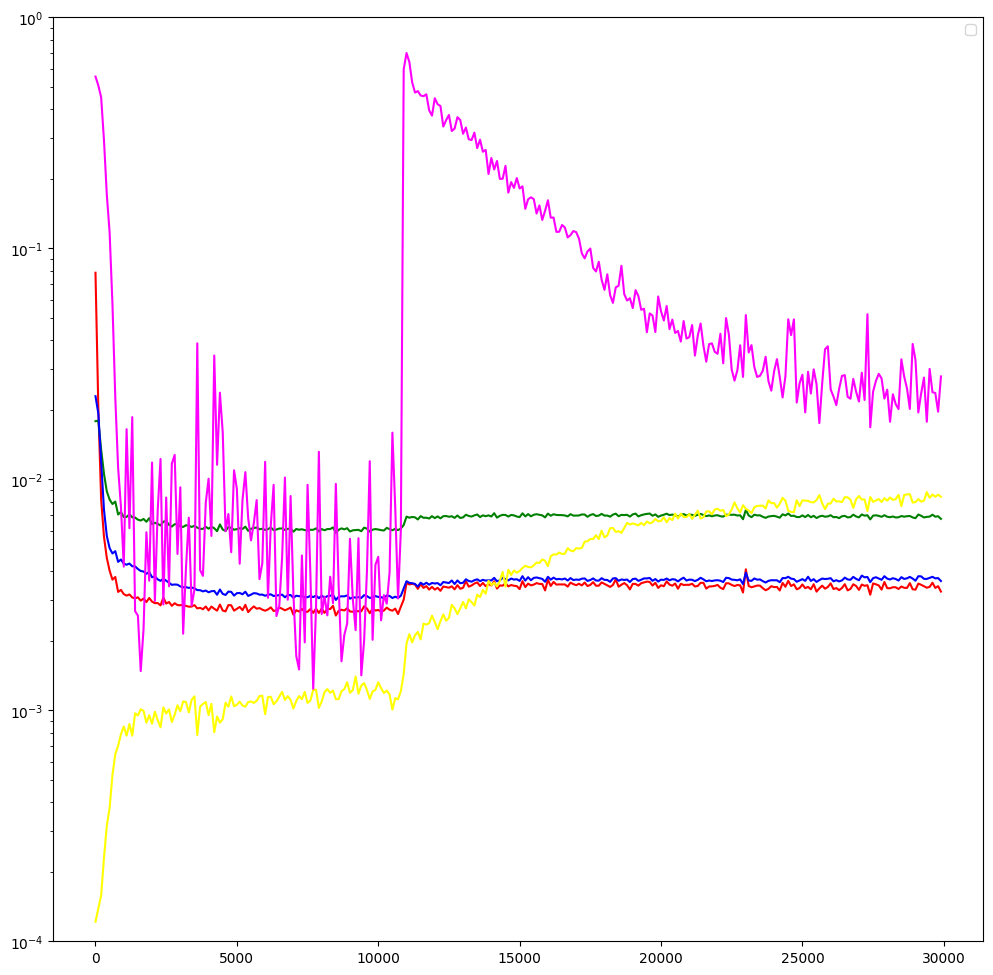

In [20]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(0.0001, 1)

def my_plot(lst: List[float], av: int):
    for i, color in enumerate(["red", "green", "blue", "yellow", "magenta"]):
        arr = np.array(lst)[:, i]
        arr = arr[:arr.shape[0] // av * av]
        arr = arr.reshape(-1, av).mean(axis=1)
        ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)

my_plot(gan_helper.losses, av=100)

ax.legend()
plt.show()

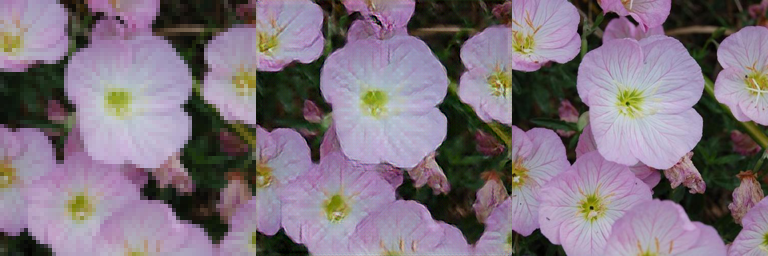

In [21]:
gan_helper.demonstrate(dataset[0])

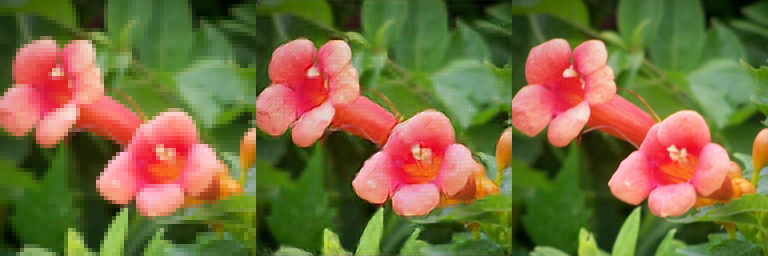

In [22]:
gan_helper.demonstrate(dataset[6])

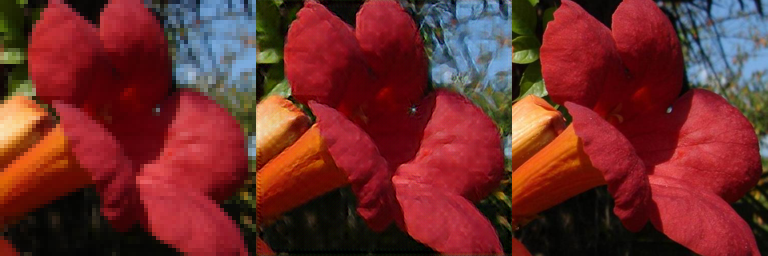

In [23]:
gan_helper.demonstrate(dataset[7])

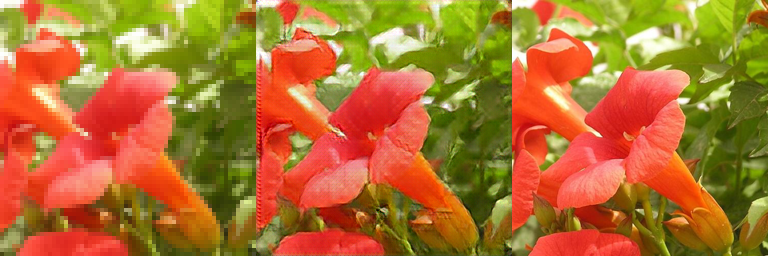

In [24]:
gan_helper.demonstrate(dataset[8])

In [25]:
gan_helper.save_model()

'2023-04-28-02-03-52'